# Kerala House Price Prediction using Machine Learning

### Introduction

Real estate valuation is a complex task influenced by multiple property and location-specific factors.
This project aims to develop a machine learning–based house price prediction system for Kerala using a non-real housing data. Traditional linear models fail to capture the non-linear behavior of housing markets, hence advanced ensemble models are explored.

### Objectives

- To analyze Kerala housing price data

- To clean and preprocess the dataset

- To identify major factors affecting house prices

- To build predictive models for accurate house price estimation

In [20]:
# load important packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load dataset

df = pd.read_csv("kerala_house_prices_500.csv")
df

,id,district,area_sqft,bedrooms,bathrooms,age_years,price_lakhs
0,1,Alappuzha,2078,2,2,8,50
1,2,Idukki,1090,2,3,18,55
2,3,Kottayam,2147,2,1,15,92
3,4,Pathanamthitta,842,2,2,9,71
4,5,Kasaragod,898,4,1,17,39
...,...,...,...,...,...,...,...
495,496,Kozhikode,2308,3,1,1,109
496,497,Alappuzha,922,4,3,3,97
497,498,Pathanamthitta,826,3,1,0,90
498,499,Kannur,1804,3,2,3,84


In [5]:
# overview of the dataset

df.info()

print("*****************************")

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           500 non-null    int64 
 1   district     500 non-null    object
 2   area_sqft    500 non-null    int64 
 3   bedrooms     500 non-null    int64 
 4   bathrooms    500 non-null    int64 
 5   age_years    500 non-null    int64 
 6   price_lakhs  500 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 27.5+ KB
*****************************


,id,area_sqft,bedrooms,bathrooms,age_years,price_lakhs
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,1652.714000,3.506000,2.440000,9.848000,83.014000
std,144.481833,495.919769,1.149176,1.103102,6.033714,25.925858
min,1.000000,802.000000,2.000000,1.000000,0.000000,30.000000
25%,125.750000,1198.750000,2.000000,1.000000,5.000000,64.000000
50%,250.500000,1640.500000,3.500000,2.000000,9.000000,83.000000
75%,375.250000,2106.500000,5.000000,3.000000,15.250000,98.000000
max,500.000000,2500.000000,5.000000,4.000000,20.000000,160.000000


In [3]:
# finding out null values

df.isnull().sum()

id             0
district       0
area_sqft      0
bedrooms       0
bathrooms      0
age_years      0
price_lakhs    0
dtype: int64

In [6]:
# Remove Outliers using IQR

def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

numeric_cols = ["area_sqft", "bedrooms", "bathrooms", "age_years", "price_lakhs"]
df = remove_outliers_iqr(df, numeric_cols)

In [7]:
# Feature Engineering

df["price_per_sqft"] = df["price_lakhs"] / df["area_sqft"]
df["bath_bed_ratio"] = df["bathrooms"] / df["bedrooms"]
df["age_sqft_interaction"] = df["age_years"] * df["area_sqft"]

df

,id,district,area_sqft,bedrooms,bathrooms,age_years,price_lakhs,price_per_sqft,bath_bed_ratio,age_sqft_interaction
0,1,Alappuzha,2078,2,2,8,50,0.024062,1.000000,16624
1,2,Idukki,1090,2,3,18,55,0.050459,1.500000,19620
2,3,Kottayam,2147,2,1,15,92,0.042850,0.500000,32205
3,4,Pathanamthitta,842,2,2,9,71,0.084323,1.000000,7578
4,5,Kasaragod,898,4,1,17,39,0.043430,0.250000,15266
...,...,...,...,...,...,...,...,...,...,...
495,496,Kozhikode,2308,3,1,1,109,0.047227,0.333333,2308
496,497,Alappuzha,922,4,3,3,97,0.105206,0.750000,2766
497,498,Pathanamthitta,826,3,1,0,90,0.108959,0.333333,0
498,499,Kannur,1804,3,2,3,84,0.046563,0.666667,5412


In [9]:
# Remove extreme luxury noise

df = df[df["price_lakhs"] < df["price_lakhs"].quantile(0.95)]

In [10]:
# Encode district

df = pd.get_dummies(df, columns=["district"], dtype=int)
df

,id,area_sqft,bedrooms,bathrooms,age_years,price_lakhs,price_per_sqft,bath_bed_ratio,age_sqft_interaction,district_Alappuzha,...,district_Kasaragod,district_Kollam,district_Kottayam,district_Kozhikode,district_Malappuram,district_Palakkad,district_Pathanamthitta,district_Thiruvananthapuram,district_Thrissur,district_Wayanad
0,1,2078,2,2,8,50,0.024062,1.000000,16624,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1090,2,3,18,55,0.050459,1.500000,19620,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2147,2,1,15,92,0.042850,0.500000,32205,0,...,0,0,1,0,0,0,0,0,0,0
3,4,842,2,2,9,71,0.084323,1.000000,7578,0,...,0,0,0,0,0,0,1,0,0,0
4,5,898,4,1,17,39,0.043430,0.250000,15266,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,2308,3,1,1,109,0.047227,0.333333,2308,0,...,0,0,0,1,0,0,0,0,0,0
496,497,922,4,3,3,97,0.105206,0.750000,2766,1,...,0,0,0,0,0,0,0,0,0,0
497,498,826,3,1,0,90,0.108959,0.333333,0,0,...,0,0,0,0,0,0,1,0,0,0
498,499,1804,3,2,3,84,0.046563,0.666667,5412,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# features and target variables

X = df.drop(["id", "price_lakhs"], axis=1) # features
Y = df["price_lakhs"]

In [12]:
# Train Test Split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
# Random Forest Model

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=18,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=18, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=400, n_jobs=-1, random_state=42)

In [14]:
# Prediction

Y_pred = model.predict(X_test)

In [15]:
# Evaluating the model

print("\nModel Performance:")
print("MAE :", mean_absolute_error(Y_test, Y_pred))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("R2  :", r2_score(Y_test, Y_pred))


Model Performance:
MAE : 2.4333320088151567
RMSE: 3.701974509755559
R2  : 0.9648772880439148


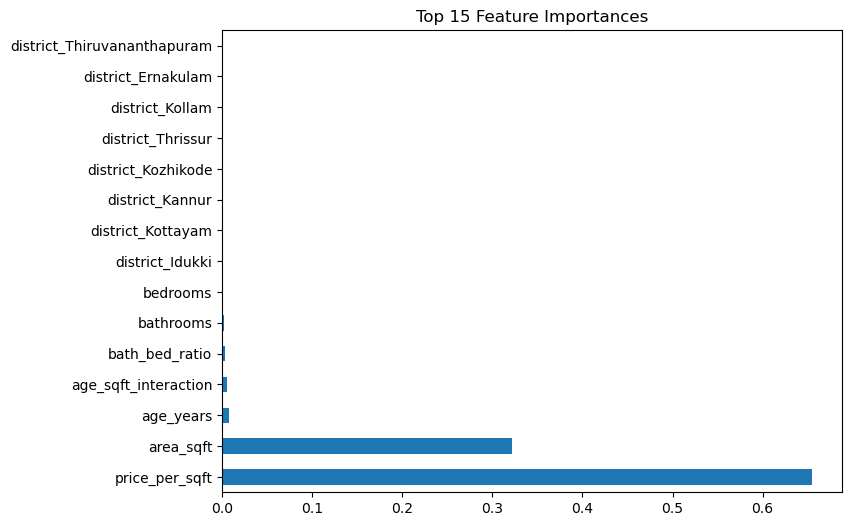

In [16]:
# Feature Importance

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(15).plot(kind="barh", figsize=(8,6))
plt.title("Top 15 Feature Importances")
plt.show()

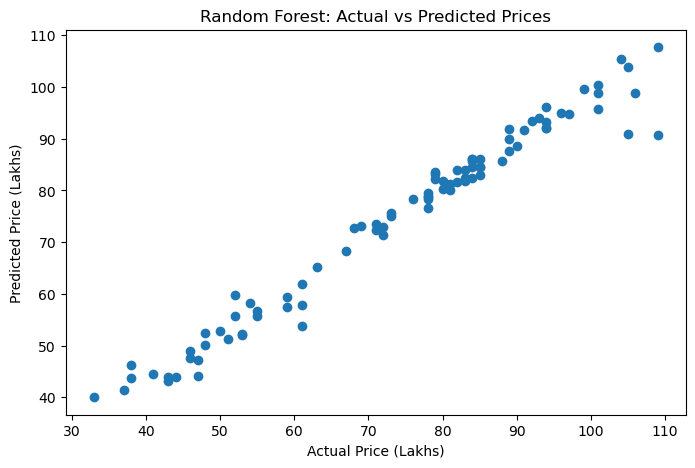

In [18]:
# Actual vs Predicted Plot

plt.figure(figsize=(8,5))
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Price (Lakhs)")
plt.ylabel("Predicted Price (Lakhs)")
plt.title("Random Forest: Actual vs Predicted Prices")
plt.show()

In [22]:
# predicting house price having area_sqft = 2500, bedrooms = 3, bathrooms= 2, age_years= 10, district = Thiruvananthapuram

input_data = dict.fromkeys(X.columns, 0)

input_data["area_sqft"] = 2500
input_data["bedrooms"] = 3
input_data["bathrooms"] = 2
input_data["age_years"] = 10
input_data["district_Thiruvananthapuram"] = 1

df_input = pd.DataFrame([input_data])

df_input["price_per_sqft"] = 0.04      # average Kerala rate approx (placeholder)
df_input["bath_bed_ratio"] = df_input["bathrooms"] / df_input["bedrooms"]
df_input["age_sqft_interaction"] = df_input["age_years"] * df_input["area_sqft"]


df_input = df_input[X.columns]

predicted_price = model.predict(df_input)

print("Predicted House Price (Lakhs):", round(predicted_price[0],2))

Predicted House Price (Lakhs): 96.31


In [19]:
# Save Model

joblib.dump({
    "model": model,
    "columns": X.columns
}, "kerala_house_price_rf.pkl")

print("\nRandom Forest model saved successfully!")


Random Forest model saved successfully!


### Results

###### The Random Forest model achieved:

- High predictive accuracy

- Lower prediction error (MAE, RMSE)

- Better handling of non-linear patterns

###### Key influential factors identified:

- Area of the house

- Price per square foot

- District

- Age-area interaction

### Conclusions

- Linear regression is insufficient for house price prediction due to non-linear market behavior.

- Ensemble models like Random Forest dramatically improve accuracy.

- Feature engineering plays a crucial role in improving model intelligence.

- The developed system can reliably estimate house prices across Kerala.